In [220]:
from modsim import *
import math
import pandas as pd
from random import randint 

# LIMESHARE 

- limeshare is...




## Below is our state with attributes:
- **number_of_scooters:** scooters deployed in region (20-120)
- **av_batt_life:** the average battery life of number_of_scooters a value from (0-100)
- **size_of_region:** the square acres of a region (200-2000)
- **send_truck:** the hour when we send our truck to recharge all scooters (0-23)
- **delta_by_hour:** the change in av_batt_life in each hourly step

In [221]:
limeshare = State(number_of_scooters = 20, av_batt_life = 100, size_of_region = 200, send_truck = -1, delta_by_hour = [])
limeshare

,values
number_of_scooters,20
av_batt_life,100
size_of_region,200
send_truck,-1
delta_by_hour,[]


## step for the hour 
- simulates usage of scooters in a region for one hour 
- if the av_batt_life is < 20 calls for truck to recharge scooters

In [222]:
def step(state, hour):
#     find number of users per hour (rush hour = more users)
#     returns a num between (0, state.number_of_scooters)
    demand = calcDemand(state.number_of_scooters, hour)
    
#     find the average ride length per rider from demand (bigger region = higher av length of use)
#     returns a num between ~(10-60)
    length_of_use = calcAverageRide(state.size_of_region, demand)
    
#     calc change in battery 
    calcBattDelta(state, int(state.number_of_scooters/5), length_of_use)
    
#   adds latest changes in av_batt_life
    state.delta_by_hour.append(state.av_batt_life)
    
#     find hour to send truck
    if(state.av_batt_life < 20 and state.send_truck == -1):
        sendTruck(state, hour)


## Calculate demand for scooters based on: 
- traffic times 
    - HIGH : going to work (8-10pm), lunch time (12-2pm), going home (4-6pm)
    - NUETRAL : early birds (6-8am), night outs (8pm-11pm)
    - LOW : all remaining times
- scooters in the area (this is a hard max) 
- randomize using round (say bad weather hour)


**Returns num of scooters with range (0, number_of_scooters)**
   - the lowest possible demand is zero and the highest is number of scooters int that region

In [223]:
def calcDemand(scooters, hour):
    if hour >= 8 and hour < 10 or hour >= 12 and hour < 14 or hour >= 16 and hour < 18:
        return int(scooters - 2) 
    elif hour == 6 or hour == 7 or hour >= 20 and hour < 23:  
        return int(scooters - 4)
    else: 
        if hour == 0:
            return int(scooters - 5)
        else:
            return int(scooters - 5)

**The following code is used to test ideal hour ranges for our function above with demand.**
- the goal was to have a higher min for higher traffic times compatible with sccoter amounts range(20-100)


| trafffic | min  | max  | av |  
|:---|---|---|---|
| high  (13)| 13  |100   |   57.03|   
| nuetral  (20)| 1  | 100  |  48.34 |   
| low (4)|  0 |  25 |  12.55 |   
[This is for 100 scooters]


| trafffic | min  | max  | av |  
|:---|---|---|---|
| high  (13)|   7|20   |   13.08|   
| nuetral  (20)| 0  | 20  |  10.6 |   
| low (4)|  0 | 5  | 2.37  |   
[This is for 20 scooters]

In [224]:
# have to rewrite minimum var from min to 'mini' below bc min is reserved 
hours, mini, max, av = 4, 100, 0, 0
for i in range(1, 100):
    store = calcDemand(100, hours)
    if store < mini: mini = store
    if store > max: max = store
    av += store
print(mini, max, av/100)

95 95 94.05


## Caluculate average ride length of scooters used 

**factors the affect the ride length**
- area of region (the higher the area the longer the ride)
- demand (if there is more demand, chances are the rides are longer)

**Ranges for inputs**
- demand: from 10-70 ore more
- areas: 200 - 2000 acres

**returns average length scooters used for the hour with range (~10, ~60) min**
- check the test methods below 

In [225]:
def calcRide(area):
    return int(area/60) 

def calcAverageRide(area, demand):
    av = 0
    for i in range (0, demand): 
        av += calcRide (area);
    return av/demand if demand > 0 else 0

Test the method above with av demand of 30 scooters and area range 500-2k acres

In [226]:
print(calcAverageRide(500, 30), calcAverageRide(1000, 30), calcAverageRide(2000, 30))

8.0 16.0 33.0


## Calc changes in average battery life of region from demand 
We came up with a simple formula in class. The whole point of the fucntion is to check how much battery goes down from sccoter usage 

### CASE STUDY:
- lets say before method is called we have 20 scooters (s) in region with av battery life of 100 percent (c) 
- this means all the scooters in this regions is fully charged
- if let's say the demand is only 1 scooter (t) and we say that scooter charge after use goes down 10 percent (d)  
- then the average for all the scooters decreases by a little but exactly how much ?  
<br/>

#### The new average battery life of the region can be calculated by finding... 
- **batt_not_used:** The av of scooters that were'nt used times the charge 
    - so 19\*100 OR (s-t)\*c = 1900
- **batt_used:** the average of scooters that were used times the charge delta 
    - so 1\*90 OR t(c-d) = 90
- the new average of the region is thus 
    - (batt_not_used + batt_used) / s = (1900 + 90) / 20 = 99.5

THE FORMULA
- ((s-t)*c + t*(c- d)) / s
    

**Inputs range**
- state: as defined
- demand: same as inputs range for calcDemand() which is (0, state.number_of_scooters) or (0-120ish) for this model
- av_length_of_use: same as inputs range for calcAvRide() which is (~10, ~60)

In [252]:
def calcBattDelta(state, demand, av_length_of_use):
    s = state.number_of_scooters 
    c = state.av_batt_life
    t = demand
    d = (av_length_of_use / 60)*100
    
    state.av_batt_life =  math.floor(((s-t)*c + t*(c- d)) / s)
        

def sendTruck(state, hour):
    state.send_truck = hour;

SyntaxError: invalid syntax (<ipython-input-252-4e278355027e>, line 7)

In [ ]:
for 

## a day in a region with scooters
- simulates usage of scooters in a region for one day
- if we have found the hour to send truck, we have found what is needed and exit

In [228]:
def run_simulation(state, num_steps):     
    results = TimeSeries()
    for hour in range(num_steps):
        #  this is our line in the sand to prevent calculating after our desired purpose for the model has been found
        if(state.send_truck != -1):
            return
        step(state, hour)
        results[hour] = state.av_batt_life

In [229]:
limeshare = State(number_of_scooters = 20, av_batt_life = 100, size_of_region = 200, send_truck = -1, delta_by_hour = [])
run_simulation(limeshare, 24)
limeshare

,values
number_of_scooters,20
av_batt_life,76
size_of_region,200
send_truck,-1
delta_by_hour,"[99, 98, 97, 96, 95, 94, 93, 92, 91, 90, 89, 8..."


## run_simulation Test A:  
#### variable *size_of_region*, fixed  *number_of_scooters*
- testing acres from 200 to 1000 in increments of 200
- tuple array ( region size, hour truck sent, first batt delta recorded, last batt delta recorded)
- expectation : with larger region we need to send the truck earlier


In [230]:
def runModel():
    regions = linspace(200, 2000, 100)
    results = []
    for i in regions:
        limeshare = State(number_of_scooters = 20, av_batt_life = 100, size_of_region = round(i + 1), send_truck = -1, delta_by_hour = [])
        run_simulation(limeshare, 24)
        data = (limeshare.size_of_region, limeshare.send_truck, len(limeshare.delta_by_hour), limeshare.delta_by_hour[0] )
        results.append(data)
    return results 

[24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 8, 8, 8, 8, 8, 8, 8, 8]
[99, 99, 99, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 97, 97, 97, 97, 97, 97, 97, 97, 97, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 89, 89, 89, 89, 89, 89, 89, 89]


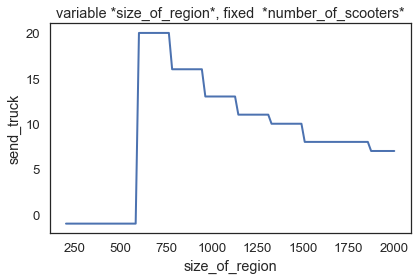

In [231]:
sample_regions = runModel()
plot([x[0] for x in sample_regions], [x[1] for x in sample_regions], label='')
def decorate_limeshare():
    """Add a title and label the axes."""
    decorate(title='variable *size_of_region*, fixed  *number_of_scooters*',
             xlabel='size_of_region', 
             ylabel='send_truck')
# print([x[0] for x in sample_regions])
# print([x[1] for x in sample_regions])
print([x[2] for x in sample_regions])
print([x[3] for x in sample_regions])
decorate_limeshare()

## run_simulation Test B:  
#### variable  *number_of_scooters*, fixed *size_of_region*
- testing scooters from 20 to 200 
- tuple array ( scooter amount, hour truck sent, first batt delta recorded, last batt delta recorded)
- expectation : with more scooters we need to send the truck LATER

In [242]:
def runModel():
#     tuple array (number_of_scooters, send_truck) with fixed size_of_region at 2
    scooters = linspace(20, 200, 100)
    results = []
    for i in scooters:
        limeshare = State(number_of_scooters = int(i), av_batt_life = 100, size_of_region = 1000, send_truck = -1, delta_by_hour = [])
        run_simulation(limeshare, 24)
        data = (limeshare.number_of_scooters, limeshare.send_truck, len(limeshare.delta_by_hour), limeshare.delta_by_hour[0] )
        results.append(data)
    return results 

[14, 14, 17, 14, 17, 17, 14, 17, 17, 14, 17, 14, 14, 17, 14, 14, 17, 14, 14, 17, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14]
[94, 94, 95, 94, 95, 95, 94, 95, 95, 94, 95, 94, 94, 95, 94, 94, 95, 94, 94, 95, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94]


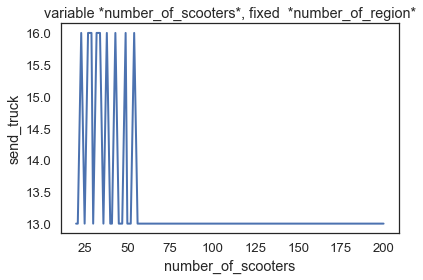

In [245]:
sample_scooters = runModel()
plot([x[0] for x in sample_scooters], [x[1] for x in sample_scooters], label='')
def decorate_limeshare():
    """Add a title and label the axes."""
    decorate(title='variable *number_of_scooters*, fixed  *number_of_region*',
             xlabel='number_of_scooters',
             ylabel='send_truck')
# print([x[0] for x in sample_scooters])
# print([x[1] for x in sample_scooters])
print([x[2] for x in sample_scooters])
print([x[3] for x in sample_scooters])
decorate_limeshare()

## Test B: results 
- this function is testing the ability of the demand function, since the larger the scooter amount the larger the deamnd
- however sicne the demand func is fixed I believe its our formula above thats setting our range  very close
- we wopuld like a more liner ratehr flat distribution 

## run_simulation Test C:  
#### variable  *number_of_scooters*, fixed *size_of_region*
- testing with how calc Batt delta fucntion calculates hard data 
- expectation : with more scooters we need to send the truck LATER

In [246]:
region_data = linspace(200, 2000, 10)


In [247]:
scooter_data = linspace(20, 80, 10)

In [248]:
truck_data = [[0 for x in region_data] for y in scooter_data] 

In [249]:
def runModel():
    for row, reigon in enumerate(region_data):
        for col, scooters in enumerate(scooter_data):
            limeshare = State(number_of_scooters = round(scooters), av_batt_life = 100, size_of_region = round(reigon), send_truck = -1, delta_by_hour = [])
            run_simulation(limeshare, 24)
            truck_data[row][col] = limeshare.send_truck

runModel()
truck_data

[[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
 [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
 [20, 20, 20, 20, 20, 20, 20, 20, 20, 20],
 [16, 16, 20, 16, 16, 16, 16, 16, 16, 16],
 [13, 16, 16, 13, 13, 13, 13, 13, 13, 13],
 [11, 11, 11, 11, 11, 11, 11, 11, 11, 11],
 [10, 10, 11, 10, 10, 10, 10, 10, 10, 10],
 [8, 8, 10, 8, 8, 8, 8, 8, 8, 8],
 [8, 8, 8, 8, 8, 8, 8, 8, 8, 8],
 [7, 7, 8, 7, 7, 7, 7, 7, 7, 7]]

In [250]:
# My reaction when the above code printed "HOLY SHIT!"

In [251]:
new_dataFrame = pd.DataFrame(data=truck_data, index=round(region_data, 2), columns=round(scooter_data, 2))
new_dataFrame

,20.00,26.67,33.33,40.00,46.67,53.33,60.00,66.67,73.33,80.00
200.0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
400.0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
600.0,20,20,20,20,20,20,20,20,20,20
800.0,16,16,20,16,16,16,16,16,16,16
1000.0,13,16,16,13,13,13,13,13,13,13
1200.0,11,11,11,11,11,11,11,11,11,11
1400.0,10,10,11,10,10,10,10,10,10,10
1600.0,8,8,10,8,8,8,8,8,8,8
1800.0,8,8,8,8,8,8,8,8,8,8
2000.0,7,7,8,7,7,7,7,7,7,7
